In [64]:
import os
import random
import tifffile
import numpy as np
from PIL import Image
from scipy import ndimage
from datasets import Dataset
from patchify import patchify  #To handle large images
import matplotlib.pyplot as plt


In [65]:
large_images = tifffile.imread('../../2 Extracted Data/smaller set to practice /stack_image.tiff')
large_masks = tifffile.imread('../../2 Extracted Data/smaller set to practice /stack_GT.tiff')

print(large_images.shape)

# Resize function
def resize_image(image, size=(256, 256)):
    image_pil = Image.fromarray(image)
    return np.array(image_pil.resize(size, Image.NEAREST))



# Resize all images and masks
resized_images = np.array([resize_image(img) for img in large_images])
resized_masks = np.array([resize_image(mask) for mask in large_masks])

print("Resized shape of images:", resized_images.shape)
print("Resized shape of masks:", resized_masks.shape)

(636, 512, 512)
Resized shape of images: (636, 256, 256)
Resized shape of masks: (636, 256, 256)


In [66]:
def convert_grayscale_to_rgb(image):
    # Ensure the image is a NumPy array
    if not isinstance(image, np.ndarray):
        raise ValueError("Image must be a NumPy array")
    
    # Stack the grayscale image along the last axis to create an RGB image
    return Image.fromarray(np.stack([image] * 3, axis=-1))

# Convert the filtered images to RGB
filtered_images_rgb = [convert_grayscale_to_rgb(img) for img in resized_images]
filtered_masks_pil = [Image.fromarray(mask) for mask in resized_masks]

# Create a dictionary with the processed images and masks
dataset_dict = {
    "image": filtered_images_rgb,
    "label": filtered_masks_pil,}

# # Create the dataset
# dataset = Dataset.from_dict(dataset_dict)
# dataset

In [67]:
# # Create the dataset
dataset = Dataset.from_dict(dataset_dict)
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 636
})

In [68]:
# Retrieve an example from the dataset
example = dataset[100]
image = example["image"]
label = example["label"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


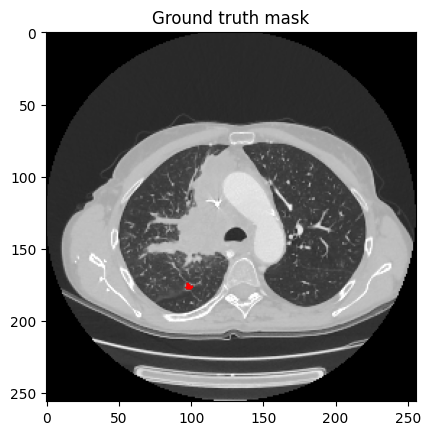

In [69]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([1, 0, 0, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image, cmap='gray')

# Plot the image and mask
fig, axes = plt.subplots()

axes.imshow(np.array(image), cmap='gray')
ground_truth_seg = np.array(label)
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
# axes.axis("off")

plt.show()

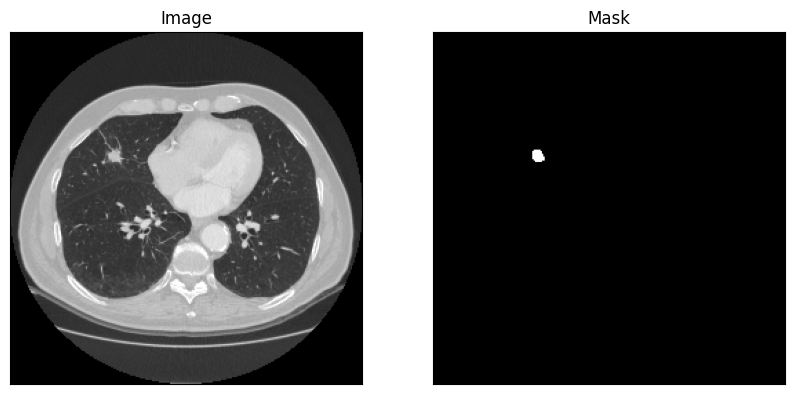

In [70]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Generate a random index to select an example from the dataset
img_num = random.randint(0, len(filtered_images_rgb) - 1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(np.array(example_mask), cmap='gray')  # Assuming the mask is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


In [71]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [72]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    # image = convert_grayscale_to_rgb(np.array(item["image"]))
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [73]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [74]:
example = train_dataset[0]

for k, v in example.items():
    print(k, v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [75]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [76]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [80]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [81]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [82]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [83]:

from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 318/318 [04:39<00:00,  1.14it/s]


EPOCH: 0
Mean loss: -2732.363901232961


100%|██████████| 318/318 [04:36<00:00,  1.15it/s]


EPOCH: 1
Mean loss: -9648.18992641137


100%|██████████| 318/318 [04:36<00:00,  1.15it/s]


EPOCH: 2
Mean loss: -17686.566810367993


100%|██████████| 318/318 [04:36<00:00,  1.15it/s]


EPOCH: 3
Mean loss: -29155.114967682075


100%|██████████| 318/318 [04:36<00:00,  1.15it/s]

EPOCH: 4
Mean loss: -45306.01196010758


In [84]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "SAM 256 X 256.pth")